## Artificial Neural Network (ANN) to predict the lung pressure

In this notebook, we try out different ANN's and finds the best model which could fit our very different pressure profiles better. <br>
In our case, out of the 4 ANN models calculated here, <span style="color:red">**model 4**</span> is the best model sofar for this
particular problem to predict the lung pressure

### What is ANN?

Neural networks reflect the behavior of the human brain, allowing computer programs to recognize patterns and solve common problems in the fields of AI, machine learning, and deep learning. Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. <br>
Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network. For more details, refer : [ANN](https://www.ibm.com/cloud/learn/neural-networks)

### ANN Architecture:

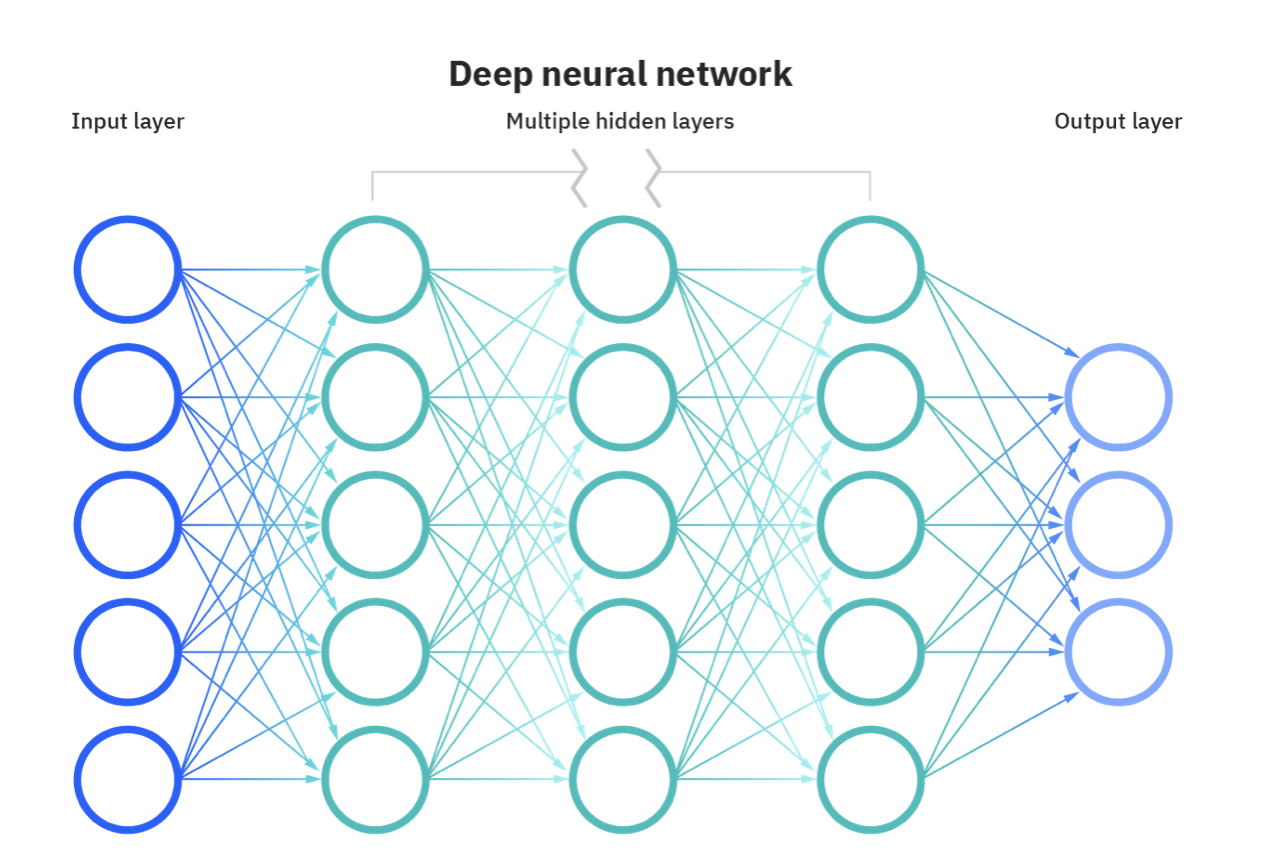

In [182]:
from IPython.display import Image
Image(filename='images/ann.png', width = 600, height = 400)

Importing packages

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import datetime, time, os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
#from datetime import datetime
from sklearn import metrics # for the evalution
import warnings
from tensorflow.keras import regularizers
warnings.filterwarnings("ignore")
RSEED=42
tf.random.set_seed(42)
np.random.seed(42)

Defining an function that has to be used later for plotting the errors

In [176]:
def error_analysis(y_test, y_pred_test):
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((np.min(y_pred_test)-10), (np.max(y_pred_test)+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([y_test.min(), y_test.max()], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((np.min(y_pred_test)-10), (np.max(y_pred_test)+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

Importing data

In [108]:
df = pd.read_csv('data/train.csv') # Original train data 
more_var = pd.read_csv('data/all_featsv4.csv') # feature engineered and time shifted data

Checking the columns and shape of the train data frame

In [4]:
print(df.columns)
print(df.shape)

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')
(6036000, 8)


Checking the columns and shape of the additional data frame

In [5]:
print(more_var.columns)
print(more_var.shape)

Index(['id', 'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'mae1', 'utm1',
       'utm2', 'utm3', 'asc', 'std', 'mean', 'vol', 'rtime', 'u_in_cumsum',
       'exponent', 'factor', 'vf', 'vt', 'v', 'step_id', 'pm1', 'pm2', 'pm3'],
      dtype='object')
(6036000, 28)


Merging 2 dataframes

In [6]:
new_df = df.merge(more_var, how='inner', on='id')
print(new_df.columns)
print(new_df.shape)

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure',
       'a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2',
       'utm3', 'asc', 'std', 'mean', 'vol', 'rtime', 'u_in_cumsum', 'exponent',
       'factor', 'vf', 'vt', 'v', 'step_id', 'pm1', 'pm2', 'pm3'],
      dtype='object')
(6036000, 35)


Selecting useful columns

In [7]:
cols=['R', 'C', 'u_in', 'u_out', 'pressure','a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 
      'h1', 'mae1', 'utm1', 'utm2', 'utm3', 'asc', 'std', 'mean', 'vol', 'rtime', 
      'u_in_cumsum', 'exponent', 'v', 'pm1', 'pm2', 'pm3']
red_df=new_df[cols]
print(red_df.columns)
print(red_df.shape)

Index(['R', 'C', 'u_in', 'u_out', 'pressure', 'a1', 'b1', 'c1', 'd1', 'e1',
       'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2', 'utm3', 'asc', 'std', 'mean',
       'vol', 'rtime', 'u_in_cumsum', 'exponent', 'v', 'pm1', 'pm2', 'pm3'],
      dtype='object')
(6036000, 28)


Splitting the data into train and test and scaling the data using the function Standard scalar

In [8]:
#train test split
target="pressure"
X = red_df.drop(target, axis=1)
y = red_df.loc[:,target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=RSEED, shuffle=False)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

#Scaling the data
scaler= StandardScaler()
col_names = ['R', 'C', 'u_in', 'u_out', 'a1', 'b1', 'c1', 'd1', 'e1',
       'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2', 'utm3', 'asc', 'std', 'mean',
       'vol', 'rtime', 'u_in_cumsum', 'exponent', 'v', 'pm1', 'pm2', 'pm3' ]
X_train_num=X_train[col_names].copy()

X_train[col_names] = scaler.fit_transform(X_train[col_names])
X_test[col_names] = scaler.transform(X_test[col_names])

X_train shape: (4225200, 27)
y_train shape: (4225200,)
X_test shape: (1810800, 27)
y_test shape: (1810800,)


Creating logs to store the model in separate folders under separate names so that its easy to reuse it later

In [9]:
# With this command you can clear any logs from previous runs
# If you want to compare different runs you can skip this cell 
!rm -rf my_logs/

In [10]:
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "ann_new_log2")
root_logdir

'./ann_new_log2'

In [11]:
# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

In [12]:
run_logdir = get_run_logdir()
run_logdir

'./ann_new_log2/run_13_05_2022-11_40_55'

In [13]:
# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

Normalizing the selected features to be used in ANN and thereby adjusting the shape of the the input data so <br>
that its fits the input data shape for an ANN to work 

In [14]:
#choosing the variable and normalizing it: Here whole train data
new_var = np.array(X_train)

new_all_normalizer = preprocessing.Normalization(input_shape = [27,], axis = None)
new_all_normalizer.adapt(new_var)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-05-13 11:40:58.383274: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-13 11:40:58.383425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-05-13 11:40:59.147066: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-13 11:40:59.299849: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-13 11:40:59.315570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


<span style="color:White">**Model1**</span>

Define an architecture of ANN with 5 layers each of shape 80, with 'relu' activation function

In [17]:
#Build a model
#Build a model
def build_and_compile_model1(norm):
    model = keras.Sequential([norm,
        layers.Dense(80, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(80, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(80, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(80, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(80, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mae',
                  metrics='mae',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

# model.compile(loss='mae',metrics='mae',optimizer=tf.keras.optimizers.Adam(0.001))-----mae = 0.6
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

Compiling the model

In [18]:
#building the model using single input
ann_model1 = build_and_compile_model1(new_all_normalizer)

In [19]:
#model summary
ann_model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 27)               3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 80)                2240      
                                                                 
 dense_1 (Dense)             (None, 80)                6480      
                                                                 
 dense_2 (Dense)             (None, 80)                6480      
                                                                 
 dense_3 (Dense)             (None, 80)                6480      
                                                                 
 dense_4 (Dense)             (None, 80)                6480      
                                                        

Train the model for 100 epochs using a batch size of 500

In [20]:
#Train the model
#%%time
history = ann_model1.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=100,
    batch_size = 500,
    callbacks=get_callbacks("ann1"))

Epoch 1/100


2022-05-07 18:53:03.623524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - ETA: 0s - loss: 0.5330 - mae: 0.5330

2022-05-07 18:53:49.605220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - 51s 8ms/step - loss: 0.5330 - mae: 0.5330 - val_loss: 0.4057 - val_mae: 0.4057
Epoch 2/100
6761/6761 [==============================] - 50s 7ms/step - loss: 0.3989 - mae: 0.3989 - val_loss: 0.3699 - val_mae: 0.3699
Epoch 3/100
6761/6761 [==============================] - 50s 7ms/step - loss: 0.3712 - mae: 0.3712 - val_loss: 0.3502 - val_mae: 0.3502
Epoch 4/100
6761/6761 [==============================] - 50s 7ms/step - loss: 0.3497 - mae: 0.3497 - val_loss: 0.3359 - val_mae: 0.3359
Epoch 5/100
6761/6761 [==============================] - 49s 7ms/step - loss: 0.3250 - mae: 0.3250 - val_loss: 0.3208 - val_mae: 0.3208
Epoch 6/100
6761/6761 [==============================] - 49s 7ms/step - loss: 0.3046 - mae: 0.3046 - val_loss: 0.2829 - val_mae: 0.2829
Epoch 7/100
6761/6761 [==============================] - 49s 7ms/step - loss: 0.2918 - mae: 0.2918 - val_loss: 0.2795 - val_mae: 0.2795
Epoch 8/100
6761/6761 [==============================] - 49s

Plotting the train vs validation loss for model 1

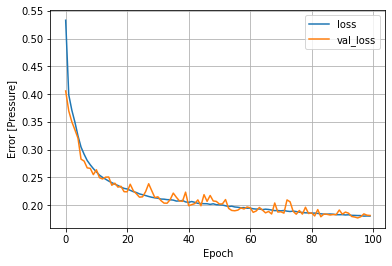

In [21]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0.5, 2.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Pressure]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

Model 1 predictions on test data

In [22]:
y_pred1 = ann_model1.predict(X_test).flatten()

2022-05-07 20:17:01.065107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating Mean Absolute Error (MAE) and Mean Square Error (MSE) for model 1 prediction on test data

In [23]:
# Evaluting model on test data
mae1 =  mean_absolute_error(y_test, y_pred1).round(2)
mse1 = mean_squared_error(y_test, y_pred1).round(2)

print('MAE:', mae1)
print('MSE', mse1)

MAE: 0.28
MSE 200.62


Setting the pressure range to be in 0-100 so that the predictions lie inside and can avoid the outliers

In [24]:
pred_imp = []
for val in y_pred1:
    if val>100.:
        pred_imp.append(100.)
    elif val<0.:
        pred_imp.append(0.)
    else:
        pred_imp.append(val)

Evaluating the errors again using new predictions

In [25]:
# Evaluting model
mae_new =  mean_absolute_error(y_test, pred_imp).round(2)
mse_new = mean_squared_error(y_test, pred_imp).round(2)

print('MAE:', mae_new)
print('MSE', mse_new)

MAE: 0.19
MSE 0.48


Creating a dictionary to store the models so that we can see scores from different models together at the end.

In [26]:
test_results = {}
test_results['ann1'] =  [mae_new, mse_new]
test_results

{'ann1': [0.19, 0.48]}

In [27]:
test_results['ann1'] = ann_model1.evaluate(
    X_test, y_test, verbose=0)

<span style="color:White">**Model2**</span>

Another ANN architecture with 5 layers of different size

In [28]:
#Build a model
#Build a model
def build_and_compile_model2(norm):
    model = keras.Sequential([norm,
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(150, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(200, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(80, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mae',
                  metrics='mae',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

# model.compile(loss='mae',metrics='mae',optimizer=tf.keras.optimizers.Adam(0.001))-----mae = 0.6
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [29]:
#building the model using single input
ann_model2 = build_and_compile_model2(new_all_normalizer)

In [30]:
#model summary
ann_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 27)               3         
 n)                                                              
                                                                 
 dense_6 (Dense)             (None, 100)               2800      
                                                                 
 dense_7 (Dense)             (None, 150)               15150     
                                                                 
 dense_8 (Dense)             (None, 200)               30200     
                                                                 
 dense_9 (Dense)             (None, 100)               20100     
                                                                 
 dense_10 (Dense)            (None, 80)                8080      
                                                      

In [31]:
#Train the model
#%%time
history2 = ann_model2.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=100,
    batch_size = 500,
    callbacks=get_callbacks("ann2_large_layer"))

Epoch 1/100


2022-05-07 20:22:30.762321: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - ETA: 0s - loss: 0.5071 - mae: 0.5071

2022-05-07 20:23:30.677131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - 66s 10ms/step - loss: 0.5071 - mae: 0.5071 - val_loss: 0.3755 - val_mae: 0.3755
Epoch 2/100
6761/6761 [==============================] - 63s 9ms/step - loss: 0.3656 - mae: 0.3656 - val_loss: 0.3195 - val_mae: 0.3195
Epoch 3/100
6761/6761 [==============================] - 63s 9ms/step - loss: 0.3220 - mae: 0.3220 - val_loss: 0.3076 - val_mae: 0.3076
Epoch 4/100
6761/6761 [==============================] - 63s 9ms/step - loss: 0.2932 - mae: 0.2932 - val_loss: 0.2802 - val_mae: 0.2802
Epoch 5/100
6761/6761 [==============================] - 63s 9ms/step - loss: 0.2731 - mae: 0.2731 - val_loss: 0.2677 - val_mae: 0.2677
Epoch 6/100
6761/6761 [==============================] - 63s 9ms/step - loss: 0.2594 - mae: 0.2594 - val_loss: 0.2605 - val_mae: 0.2605
Epoch 7/100
6761/6761 [==============================] - 63s 9ms/step - loss: 0.2493 - mae: 0.2493 - val_loss: 0.2554 - val_mae: 0.2554
Epoch 8/100
6761/6761 [==============================] - 63

Plotting train vs validation loss in the same plot

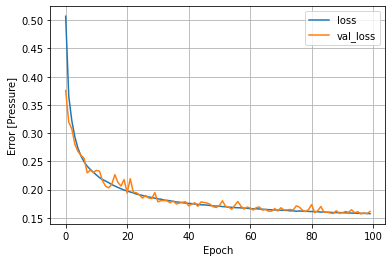

In [32]:
def plot_loss(history2):
    plt.plot(history2.history['loss'], label='loss')
    plt.plot(history2.history['val_loss'], label='val_loss')
    #plt.ylim([0.5, 2.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Pressure]')
    plt.legend()
    plt.grid(True)
plot_loss(history2)

model 2 predictions on test set

In [44]:
y_pred2 = ann_model2.predict(X_test).flatten()

2022-05-08 09:33:39.139158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Calculating the scores on test data

In [34]:
# Evaluting model on test data
mae2 =  mean_absolute_error(y_test, y_pred2).round(2)
mse2 = mean_squared_error(y_test, y_pred2).round(2)

print('MAE:', mae2)
print('MSE', mse2)

MAE: 0.28
MSE 200.62


Setting the pressure range to be in 0-100 so that the predictions lie inside and can avoid the outliers

In [35]:
pred_imp2 = []
for val2 in y_pred2:
    if val2>100.:
        pred_imp2.append(100.)
    elif val2<0.:
        pred_imp2.append(0.)
    else:
        pred_imp2.append(val2)

Evaluating the errors again using new predictions

In [36]:
# Evaluting model
mae_new2 =  mean_absolute_error(y_test, pred_imp2).round(2)
mse_new2 = mean_squared_error(y_test, pred_imp2).round(2)

print('MAE:', mae_new2)
print('MSE', mse_new2)

MAE: 0.19
MSE 0.48


Adding it to the dictionary

In [37]:
test_results['ann2_large_layer'] = ann_model2.evaluate(
    X_test, y_test, verbose=1)

56588/56588 [==============================] - 219s 4ms/step - loss: 0.1618 - mae: 0.1618


Viewing the 2 model scores together

In [38]:
pd.DataFrame(test_results, index=['Mean absolute error', 'Mean squared error']).T

,Mean absolute error,Mean squared error
ann1,0.275552,0.275552
ann2_large_layer,0.161815,0.161815


<span style="color:White">**Model3**</span>

3rd ANN model with 5 layers of size 100

In [39]:
#Build a model
#Build a model
def build_and_compile_model3(norm):
    model = keras.Sequential([norm,
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(100, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mae',
                  metrics='mae',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

# model.compile(loss='mae',metrics='mae',optimizer=tf.keras.optimizers.Adam(0.001))-----mae = 0.6
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [40]:
#building the model using single input
ann_model3 = build_and_compile_model3(new_all_normalizer)

In [41]:
#model summary
ann_model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 27)               3         
 n)                                                              
                                                                 
 dense_12 (Dense)            (None, 100)               2800      
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dense_15 (Dense)            (None, 100)               10100     
                                                                 
 dense_16 (Dense)            (None, 100)               10100     
                                                      

In [42]:
#Train the model
#%%time
history3 = ann_model3.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=100,
    batch_size = 500,
    callbacks=get_callbacks("ann3_large_layer_100"))

Epoch 1/100


2022-05-07 22:16:37.803729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - ETA: 0s - loss: 0.5273 - mae: 0.5273

2022-05-07 22:17:39.341375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - 69s 10ms/step - loss: 0.5273 - mae: 0.5273 - val_loss: 0.3979 - val_mae: 0.3979
Epoch 2/100
6761/6761 [==============================] - 66s 10ms/step - loss: 0.3794 - mae: 0.3794 - val_loss: 0.3456 - val_mae: 0.3456
Epoch 3/100
6761/6761 [==============================] - 64s 10ms/step - loss: 0.3343 - mae: 0.3343 - val_loss: 0.3064 - val_mae: 0.3064
Epoch 4/100
6761/6761 [==============================] - 64s 9ms/step - loss: 0.3061 - mae: 0.3061 - val_loss: 0.2810 - val_mae: 0.2810
Epoch 5/100
6761/6761 [==============================] - 65s 10ms/step - loss: 0.2893 - mae: 0.2893 - val_loss: 0.2968 - val_mae: 0.2968
Epoch 6/100
6761/6761 [==============================] - 64s 9ms/step - loss: 0.2757 - mae: 0.2757 - val_loss: 0.2632 - val_mae: 0.2632
Epoch 7/100
6761/6761 [==============================] - 64s 10ms/step - loss: 0.2653 - mae: 0.2653 - val_loss: 0.2649 - val_mae: 0.2649
Epoch 8/100
6761/6761 [==============================] 

Plotting train vs validation loss

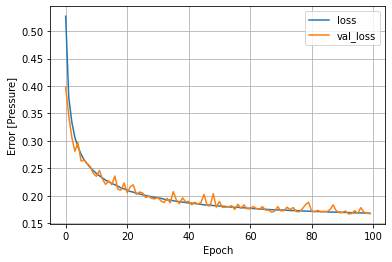

In [43]:
def plot_loss(history3):
    plt.plot(history3.history['loss'], label='loss')
    plt.plot(history3.history['val_loss'], label='val_loss')
    #plt.ylim([0.5, 2.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Pressure]')
    plt.legend()
    plt.grid(True)
plot_loss(history3)

Model3 predictions on test data

In [45]:
y_pred3 = ann_model3.predict(X_test).flatten()

2022-05-08 20:42:01.208854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [46]:
# Evaluting model on test data
mae3 =  mean_absolute_error(y_test, y_pred3).round(2)
mse3 = mean_squared_error(y_test, y_pred3).round(2)

print('MAE:', mae3)
print('MSE', mse3)

MAE: 0.35
MSE 745.11


Setting the pressure range to be in 0-100 so that the predictions lie inside and can avoid the outliers

In [47]:
pred_imp3 = []
for val3 in y_pred3:
    if val3>100.:
        pred_imp3.append(100.)
    elif val3<0.:
        pred_imp3.append(0.)
    else:
        pred_imp3.append(val3)

In [48]:
# Evaluting model
mae_new3 =  mean_absolute_error(y_test, pred_imp3).round(2)
mse_new3 = mean_squared_error(y_test, pred_imp3).round(2)

print('MAE:', mae_new3)
print('MSE', mse_new3)

MAE: 0.17
MSE 0.11


Adding it to the dictionary

In [ ]:
test_results['ann3_large_layer_100'] = ann_model3.evaluate(
    X_test, y_test, verbose=0)

visualizing 3 models scores together

In [ ]:
pd.DataFrame(test_results, index=['Mean absolute error', 'Mean squared error']).T

### <span style="color:red">**Best model**</span>

<span style="color:White">**Model4**</span>

ANN Model 4 with large 5 layers of size 300

In [15]:
#Build a model
#Build a model
def build_and_compile_model4(norm):
    model = keras.Sequential([norm,
        layers.Dense(300, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(300, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(300, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(300, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(300, kernel_initializer = 'uniform', activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mae',
                  metrics='mae',
                  optimizer=tf.keras.optimizers.Adam(0.001))
    return model

# model.compile(loss='mae',metrics='mae',optimizer=tf.keras.optimizers.Adam(0.001))-----mae = 0.6
#sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

In [16]:
#building the model using single input
ann_model4 = build_and_compile_model4(new_all_normalizer)

In [17]:
#model summary
ann_model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 27)               3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 300)               8400      
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dense_3 (Dense)             (None, 300)               90300     
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                        

In [18]:
#Train the model
#%%time
history4 = ann_model4.fit(
    X_train, y_train,
    validation_split=0.2,
    verbose=1, epochs=100,
    batch_size = 500,
    callbacks=get_callbacks("ann4_large_layer_300"))

Epoch 1/100


2022-05-13 11:44:31.836010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - ETA: 0s - loss: 0.4632 - mae: 0.4632

2022-05-13 11:45:48.841047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6761/6761 [==============================] - 85s 12ms/step - loss: 0.4632 - mae: 0.4632 - val_loss: 0.3504 - val_mae: 0.3504
Epoch 2/100
6761/6761 [==============================] - 79s 12ms/step - loss: 0.3203 - mae: 0.3203 - val_loss: 0.2762 - val_mae: 0.2762
Epoch 3/100
6761/6761 [==============================] - 78s 12ms/step - loss: 0.2828 - mae: 0.2828 - val_loss: 0.2577 - val_mae: 0.2577
Epoch 4/100
6761/6761 [==============================] - 84s 12ms/step - loss: 0.2632 - mae: 0.2632 - val_loss: 0.2482 - val_mae: 0.2482
Epoch 5/100
6761/6761 [==============================] - 78s 12ms/step - loss: 0.2493 - mae: 0.2493 - val_loss: 0.2392 - val_mae: 0.2392
Epoch 6/100
6761/6761 [==============================] - 79s 12ms/step - loss: 0.2385 - mae: 0.2385 - val_loss: 0.2316 - val_mae: 0.2316
Epoch 7/100
6761/6761 [==============================] - 81s 12ms/step - loss: 0.2308 - mae: 0.2308 - val_loss: 0.2208 - val_mae: 0.2208
Epoch 8/100
6761/6761 [==============================

Plotting the train vs validation loss for model 4

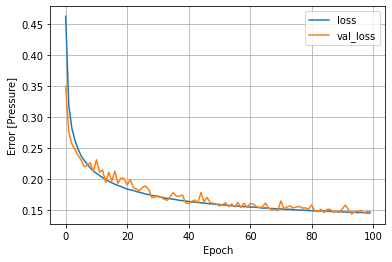

In [19]:
def plot_loss(history4):
    plt.plot(history4.history['loss'], label='loss')
    plt.plot(history4.history['val_loss'], label='val_loss')
    #plt.ylim([0.5, 2.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Pressure]')
    plt.legend()
    plt.grid(True)
plot_loss(history4)

Model 4 predictions on test data

In [21]:
y_pred4 = ann_model4.predict(X_test).flatten()

2022-05-13 14:02:13.074913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
# Evaluting model on test data
mae4 =  mean_absolute_error(y_test, y_pred4).round(2)
mse4 = mean_squared_error(y_test, y_pred4).round(2)

print('MAE:', mae4)
print('MSE', mse4)

MAE: 0.17
MSE 11.18


Setting the pressure range to be in 0-100 so that the predictions lie inside and can avoid the outliers

In [25]:
pred_imp4 = []
for val4 in y_pred4:
    if val4>100.:
        pred_imp4.append(100.)
    elif val4<0.:
        pred_imp4.append(0.)
    else:
        pred_imp4.append(val4)

In [26]:
# Evaluting model
mae_new4 =  mean_absolute_error(y_test, pred_imp4).round(2)
mse_new4 = mean_squared_error(y_test, pred_imp4).round(2)

print('MAE:', mae_new4)
print('MSE', mse_new4)

MAE: 0.15
MSE 0.45


Actual pressure vs predicted pressure from the best model

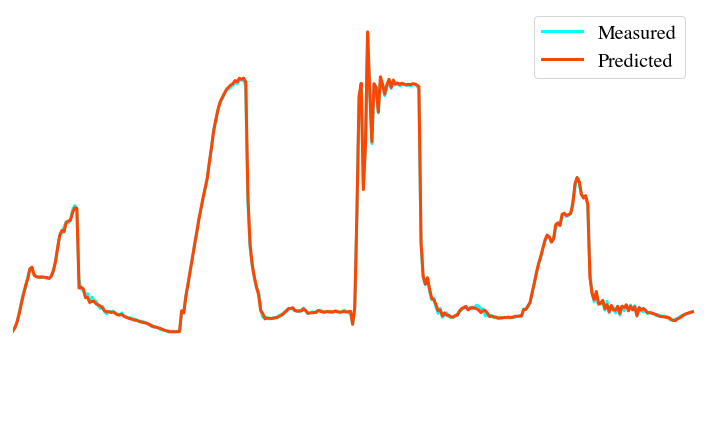

In [152]:
tickcolor = 'white'
spinecolor = 'white'
labelcolor = 'white'
titlecolor = 'white'
import matplotlib as mpl
mpl.rc('text', usetex=False)
plt.rc('font', family='times')
tick_fsize=22
label_size=23
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(111)
ax1.set_xticks([0, 319/12, 2*319/12, 3*319/12, 4*319/12, 5*319/12, 6*319/12, 7*319/12, 8*319/12, 9*319/12, 10*319/12, 11*319/12, 12*319/12])
plt.plot(y_test[1:320], label='True value', linewidth=3, color='cyan')
plt.plot(pred_imp4[1:320], label='predicted value', linewidth=3, color='orangered')
#plt.plot(y_test_poly[1:320], linewidth=3, color='cyan')
#plt.plot(test_poly_pred5[1:320], linewidth=3, color='orangered')
#plt.ylabel(r'Pressure in cm$H_2O$')
#plt.xlabel('Time in s')
plt.legend()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticklabels(np.arange(0,13,1),fontsize=tick_fsize, color=tickcolor)
#ax1.set_xticklabels(np.arange(0,13, 1),fontsize=tick_fsize, color=tickcolor)
#ax1.set_yticklabels(np.arange(0,46,5),fontsize=tick_fsize, color=tickcolor)
#ax.spines['right'].set_visible(False)
#ax.spines['top'].set_visible(False)
ax1.spines['bottom'].set_color(spinecolor)
#ax.spines['left'].set_color(spinecolor)
#ax.spines['bottom'].set_linewidth(3.)
#ax.spines['left'].set_linewidth(3.)

#ax1.set_yticklabels(np.arange(0,46,5),fontsize=tick_fsize)
ax1.set_xlabel(r'Time in s', fontsize=label_size, color=labelcolor)
ax1.spines['bottom'].set_linewidth(3.)
#ax1.set_ylabel(r'Pressure in cmH$_2$O', fontsize=label_size)
plt.xlim(0,319)
plt.ylim(0,45)
ax1.spines['left'].set_visible(False)
ax1.get_yaxis().set_visible(False)
#ax1.set_xticks([0,50,100,150,200,250,300], color=tickcolor)
ax1.tick_params('x', size=9, width=3., colors='white')
ax1.legend(labels=['Measured', 'Predicted'], fontsize=20)
plt.tight_layout()
plt.savefig('ann_ar.png', transparent=True)

Conclusion: As you can see, our model 4 predicts well the pressure with an MAE of 0.5. Above plot show the prediction vs actual <br> 
pressure for the first 300 values of pressure. There are still some place for improvement, by adding regularization methods and all! 
<br> That will be the future plan!

### Error Analysis

Even though our model predicts well with different breaths, it is important to know where does it don't work so that we get a better understanding of the limitations of our model when it comes to real life applications.

Where did our model went wrong? Lets have a look in to it!

adding the useful columns into a new dataframe

In [63]:
cols_new=['R', 'C', 'u_in', 'u_out', 'pressure','a1', 'b1', 'c1', 'd1', 'e1', 'f1', 'g1', 
      'h1', 'mae1', 'utm1', 'utm2', 'utm3', 'asc', 'std', 'mean', 'vol', 'rtime', 
      'u_in_cumsum', 'exponent', 'v', 'pm1', 'pm2', 'pm3', 'step_id', 'id']
red_df=new_df[cols_new]
print(red_df.columns)
print(red_df.shape)

Index(['R', 'C', 'u_in', 'u_out', 'pressure', 'a1', 'b1', 'c1', 'd1', 'e1',
       'f1', 'g1', 'h1', 'mae1', 'utm1', 'utm2', 'utm3', 'asc', 'std', 'mean',
       'vol', 'rtime', 'u_in_cumsum', 'exponent', 'v', 'pm1', 'pm2', 'pm3',
       'step_id', 'id'],
      dtype='object')
(6036000, 30)


Split the data into train test split

In [64]:
#train test split
target_new="pressure"
X_new = red_df.drop(target_new, axis=1)
y_new = red_df.loc[:,target_new].values

X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.3, random_state=RSEED, shuffle=False)

Checking the shape of the data

In [68]:
X_test_new.columns
X_test.shape

(1810800, 27)

Predicting the model on test set

In [69]:
df_plot = X_test_new[['R', 'C']]
df_plot['pred_pressure'] = ann_model4.predict(X_test)
df_plot['step_id'] = X_test_new.id.apply(lambda x: (x-1)%80);
df_plot['true_p'] = y_test_new

Calculating the MAE(Mean Absolute Error) for each R and C combination

In [70]:
df_plot['MAE'] = df_plot.apply(lambda row: np.abs(row.true_p-row.pred_pressure), axis=1)
RC_combs = df_plot.groupby(['R', 'C']).mean().sort_values(['R', 'C']).reset_index().MAE.to_numpy()

In [71]:
RC_combs

array([0.12546041, 0.13339412, 0.15091565, 0.13622396, 0.42359612,
       0.16822826, 0.14140805, 0.17070515, 0.16159239])

R = 5
C = 10: 0.12546041, C = 20: 0.13339412, C = 50: 0.15091565
R = 20
C = 10: 0.13622396, C = 20: 0.42359612, C = 50: 0.16822826
R = 50
C = 10: 0.14140805, C = 20: 0.17070515, C = 50: 0.16159239

Plotting the distribution of MAE for R and C combinations

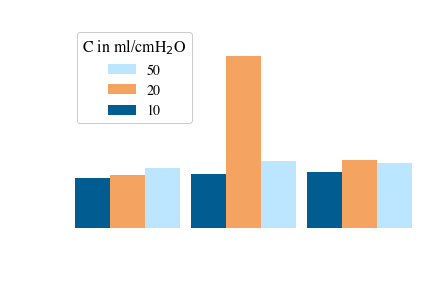

In [166]:
tickcolor = 'white'
spinecolor = 'white'
labelcolor = 'white'
titlecolor = 'white'

ticklabelsize = 20
labelsize = 20
titlesize = 34

mpl.rc('text', usetex=False)
#plt.rc('font', family='serif')

lengthC10 = [0.12546041, 0.13622396, 0.14140805]
lengthC20 = [0.13339412, 0.42359612, 0.17070515]
lengthC50 = [0.15091565, 0.16822826, 0.16159239]

### best blue combo
color3 = '#015C92'
#color2 = '#5BAEB7'
color2 = 'sandybrown'
color1 = '#BCE6FF'

#bars = ('20', '10', '50')
x_pos = np.arange(len(bars))

fig, ax = plt.subplots(1,1,figsize=(6,4))

# Create bars with different colors
bar1=plt.bar(x_pos[2]+0.3, lengthC50[2], color=[color1], width=0.3)
bar2=plt.bar(x_pos[2], lengthC20[2], color=[color2], width=0.3)
bar3=plt.bar(x_pos[2]-0.3, lengthC10[2], color=[color3], width=0.3)
bar4=plt.bar(x_pos[1]+0.3, lengthC50[1], color=[color1], width=0.3)
bar5=plt.bar(x_pos[1], lengthC20[1], color=[color2], width=0.3)
bar6=plt.bar(x_pos[1]-0.3, lengthC10[1], color=[color3], width=0.3)
bar7=plt.bar(x_pos[0]+0.3, lengthC50[0], color=[color1], width=0.3)
bar8=plt.bar(x_pos[0], lengthC20[0], color=[color2], width=0.3)
bar9=plt.bar(x_pos[0]-0.3, lengthC10[0], color=[color3], width=0.3)

# Create names on the x-axis

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_color(spinecolor)
ax.spines['left'].set_color(spinecolor)
ax.spines['bottom'].set_linewidth(3.)
ax.spines['left'].set_linewidth(3.)

ax.set_xticklabels([r'5', r'20', r'50'], fontsize=ticklabelsize, color=tickcolor)
ax.set_yticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5'], fontsize=ticklabelsize, color=tickcolor)

ax.set_xticks([0,1,2])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])

ax.set_xlabel(r'Resistance in cmH$_2$O/l/s', fontsize=labelsize, color=labelcolor)
ax.set_ylabel(r'Mean average error in cmH$_2$0', fontsize=labelsize, color=labelcolor)
ax.tick_params('both', size=9, width=3., colors=tickcolor)
plt.xlim(-0.5,2.5)
plt.ylim(0,0.5)

legend = ax.legend(title=r'C in ml/cmH$_2$O', title_fontsize=16, fontsize=14, handles=[bar1, bar2, bar3], labels=[r'50', r'20', r'10'], loc='upper left')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('silver')

plt.tight_layout()
plt.savefig('errRC.png', transparent=True)

Defining a function to calculate the MAE as a function of time step so that we can see where our model predicts wrong!

In [111]:
def my_ci2(data, perc=95):
    n=data.shape[0]

    lower_bounds = []
    upper_bounds = []
    '''calculate means'''
    means=data.groupby('step_id').MAE.mean().to_numpy()
    for step in data.step_id.unique():
        data_step=data[data['step_id']==step].MAE.to_numpy()
        data_step.sort()
        cut_index=int(perc/100.*len(data_step))
        lower_bounds.append(data_step[-cut_index])
        upper_bounds.append(data_step[+cut_index])
    return lower_bounds, means, upper_bounds

Plotting the MAE vs time step

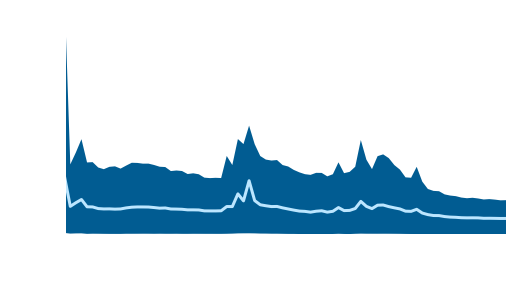

In [147]:
mpl.rc('text', usetex=False)
lines=my_ci2(df_plot)
fig=plt.figure(figsize=(7.4,4))
ax = plt.subplot(111)
linecol=color3
cicol=color1
color1 = '#015C92'
color2 = '#5BAEB7'
color3 = '#BCE6FF'
spinecolor='white'
fontcolor='white'

ticklabelsize = 18

x=np.arange(0,80,1)
plt.plot(x, lines[1], c=linecol, linewidth=3.)

ax.fill_between(x, lines[0], lines[1], facecolor=cicol)
ax.fill_between(x, lines[1], lines[2], facecolor=cicol)

plt.ylim(0, 1.4)
plt.xlim(0, 79)
ax.set_xticklabels(['0', '1.0', '2.0', '3.0'], fontsize=15.5)
#ax.set_xticks([9,19,29,39,49,59,69,79])
ax.set_xticks([0, 79/3, 79/3*2, 79])
ax.set_yticks(np.arange(0.0, 1.5, 0.2))
ax.tick_params('both', size=6, width=2., colors='white')
ax.set_yticklabels(['0', '0.2', '0.4', '0.6', '0.8', '1', '1.2', '1.4'], fontsize=15, color=fontcolor)
#ax.set_xticklabels(['10', '20', '30', '40', '50', '60', '70', '80'], fontsize=ticklabelsize, color=fontcolor)
ax.set_xlabel(r'Time in s', fontsize=15, color=fontcolor)
ax.set_ylabel(r'Mean average error in cmH$_2$O', fontsize=15.5, color=fontcolor)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_color(spinecolor)
ax.spines['bottom'].set_color(spinecolor)

ax.spines['bottom'].set_linewidth(2.)
ax.spines['left'].set_linewidth(2.)

plt.tight_layout()
plt.savefig('err_step.png', transparent=True);

Residual plots with actual and predicted values of pressure from the best model: Model 4

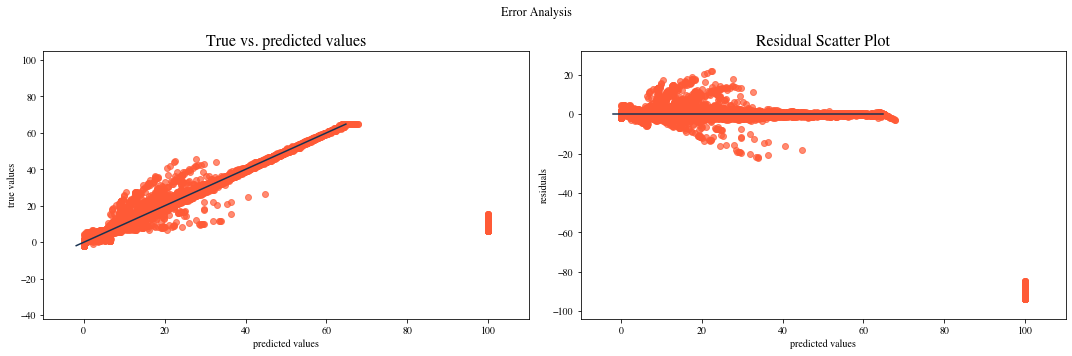

In [178]:
error_analysis(y_test, pred_imp4)
plt.tight_layout()
plt.show()

### Results:

As we can see, <span style="color:White">**Model4**</span> performed the best sofar with an MAE of 0.15. But there are errors in the predictions and also 
we can see outliers in the residual plots. <br> So there is still room for improvement. 

### Outlook:

1) Add regularization methods like l1, l2 and Dropout layers and see if the model improves <br>
2) Change the architecture of the ANN by increasing/ decreasing the number of layers and varying the size of the layers <br>
3) Varying the hyper-parameters like learning rate, epoch, optimizers and check the performance <br>
4) Try different loss functions, activation functions and check the performance.